In [1]:
from PIL import Image
import numpy as np
import cv2

train_dir = r'D:\my_deeplearn\image_classify_sdwebui\data\train'


def img_open(img_path, width, height):
    # 使用Pillow读取图像
    # img_pil = Image.open(img_path).convert("L")
    # img_np = np.stack([img_pil, img_pil, img_pil], axis=-1)
    img_pil = Image.open(img_path)
    img_np = np.array(img_pil)
    # 将RGB格式转换为BGR格式，因为OpenCV默认使用BGR格式
    img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    img_cv2 = cv2.resize(img_cv2, (width, height))
    return img_cv2

In [2]:
import random

import os
from paddle.io import Dataset
from PIL import Image


class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """

    def __init__(self, file_path_list, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        self.width = 224
        self.height = 224
        super().__init__()
        self.data_list = []
        for file_path in file_path_list:
            label = os.path.basename(os.path.dirname(file_path))
            self.data_list.append([file_path, label])
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # 根据索引，从列表中取出一个图像
        image_path, label = self.data_list[index]
        # 读取灰度图
        image = img_open(image_path, self.width, self.height)
        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype('float32').transpose(2, 0, 1)
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        label = int(label)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)

In [3]:
# 从paddle.vision.models 模块中import 残差网络，VGG网络，LeNet网络
from paddle.vision.transforms import Normalize
from paddle.vision.transforms import Compose, RandomRotation, RandomHorizontalFlip
file_name_list = []
for root, _, files in os.walk(train_dir):
    for file in files:
        file_name_list.append(os.path.join(root, file))

random.shuffle(file_name_list)
ratio = 0.2
split_point = int(len(file_name_list)*ratio)
train_file_name_list = file_name_list[split_point:]
valid_file_name_list = file_name_list[:split_point]

# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Compose([
    RandomRotation(degrees=15),  # 随机旋转，角度范围为[-15, 15]
    RandomHorizontalFlip(prob=0.5),  # 50%的概率进行水平翻转
    Normalize(mean=[127.5], std=[127.5], data_format='CHW')  # 图像归一化
])
# 打印数据集样本数
train_custom_dataset = MyDataset(train_file_name_list,  transform)
valid_custom_dataset = MyDataset(valid_file_name_list, transform)
print('train_custom_dataset images: ', len(train_custom_dataset),
      'test_custom_dataset images: ', len(valid_custom_dataset))

train_custom_dataset images:  26292 test_custom_dataset images:  6573


In [4]:
import matplotlib.pyplot as plt


def show_sample(dataset, index):
    # 获取指定索引的图像和标签
    image, label = dataset[index]

    # 因为图像是CHW格式，我们需要将其转换为HWC格式以便使用Pillow进行可视化
    image = image.transpose(1, 2, 0)

    # 反归一化 (如果你使用了Normalize)
    # image = image * 127.5 + 127.5
    # image = image.astype('uint8')

    # 使用Pillow和matplotlib显示图像
    img_pil = Image.fromarray(image)
    plt.imshow(img_pil)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [5]:
import paddle
import matplotlib.pyplot as plt


class LossAccuracyCallback(paddle.callbacks.Callback):
    def __init__(self):
        # 初始化存储丢失率和精确率的列表
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, epoch, logs):
        # 在每个epoch结束时，收集丢失率和精确率
        self.losses.append(logs['loss'])
        self.accuracies.append(logs['acc_top1'])

    def plot_metrics(self):
        # 使用matplotlib绘制丢失率和精确率的变化趋势
        epochs = range(1, len(self.losses) + 1)

        plt.figure(figsize=(12, 5))

        # 绘制丢失率
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.losses, 'r-', label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # 绘制精确率
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.accuracies, 'b-', label='Training Accuracy')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


# 创建回调实例
loss_acc_callback = LossAccuracyCallback()

In [6]:
# resnet50, vgg16, LeNet,
from paddle.vision.models import resnet18
from paddle.metric import Accuracy
from paddle.nn import CrossEntropyLoss
from paddle.regularizer import L2Decay
from paddle.optimizer import Momentum, Adam
# 确保从paddle.vision.datasets.
paddle.vision.set_image_backend('cv2')
# 创建resnet18模型实例
resnet = resnet18(pretrained=True, num_classes=2)

# 冻结所有层，除了最后的全连接层
for name, param in resnet.named_parameters():
    if "fc" not in name:  # "fc" 是resnet18中最后全连接层的名称
        param.stop_gradient = True

# 使用冻结的模型创建PaddlePaddle的Model对象
model = paddle.Model(resnet)

# 定义优化器
optimizer = Momentum(learning_rate=0.01,
                     momentum=0.9,
                     weight_decay=L2Decay(1e-4),
                     parameters=model.parameters())
# amp_configs={
#                   "level": "O1",  # 修改AMP级别
#                   "use_dynamic_loss_scaling": True
#               }
# 进行训练前准备
model.prepare(optimizer,
              CrossEntropyLoss(),
              Accuracy(topk=(1, 5)))
# 启动训练
model.fit(train_custom_dataset,
          valid_custom_dataset,
          epochs=32,
          batch_size=160,
          save_dir="./output",
          num_workers=8,
          callbacks=[loss_acc_callback])

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\layers.py:1897: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [512, 1000], but the expected shape is [512, 2].
  warnings.warn(f"Skip loading for {key}. " + str(err))
c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\layers.py:1897: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [2].
  warnings.warn(f"Skip loading for {key}. " + str(err))
c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\io\reader.py:433: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/32


c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.5504 - acc_top1: 0.7850 - acc_top5: 1.0000 - 4s/step
step  20/165 - loss: 0.4127 - acc_top1: 0.7966 - acc_top5: 1.0000 - 4s/step
step  30/165 - loss: 0.4290 - acc_top1: 0.8048 - acc_top5: 1.0000 - 4s/step
step  40/165 - loss: 0.6014 - acc_top1: 0.8066 - acc_top5: 1.0000 - 4s/step
step  50/165 - loss: 0.7732 - acc_top1: 0.8020 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4823 - acc_top1: 0.8013 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.5227 - acc_top1: 0.8067 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4535 - acc_top1: 0.8086 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4456 - acc_top1: 0.8081 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3966 - acc_top1: 0.8114 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4634 - acc_top1: 0.8133 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3723 - acc_top1: 0.8155 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.5357 - acc_top1: 0.8157 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4268 - acc_top1: 0.8244 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4309 - acc_top1: 0.8234 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4378 - acc_top1: 0.8217 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4701 - acc_top1: 0.8275 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.5357 - acc_top1: 0.8284 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3828 - acc_top1: 0.8291 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3786 - acc_top1: 0.8296 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4050 - acc_top1: 0.8320 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4394 - acc_top1: 0.8315 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3449 - acc_top1: 0.8316 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.5138 - acc_top1: 0.8320 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4383 - acc_top1: 0.8332 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4436 - acc_top1: 0.8334 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4226 - acc_top1: 0.8325 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3545 - acc_top1: 0.8244 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3912 - acc_top1: 0.8260 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3703 - acc_top1: 0.8320 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3838 - acc_top1: 0.8319 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3548 - acc_top1: 0.8303 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.5616 - acc_top1: 0.8300 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4742 - acc_top1: 0.8282 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3854 - acc_top1: 0.8286 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.5772 - acc_top1: 0.8294 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4428 - acc_top1: 0.8312 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4046 - acc_top1: 0.8321 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4301 - acc_top1: 0.8314 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4602 - acc_top1: 0.8369 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4336 - acc_top1: 0.8344 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4283 - acc_top1: 0.8344 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4774 - acc_top1: 0.8317 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4882 - acc_top1: 0.8265 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3837 - acc_top1: 0.8226 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4361 - acc_top1: 0.8233 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3392 - acc_top1: 0.8242 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4038 - acc_top1: 0.8263 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4274 - acc_top1: 0.8267 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4119 - acc_top1: 0.8260 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4471 - acc_top1: 0.8256 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.2835 - acc_top1: 0.8268 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4453 - acc_top1: 0.8519 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4516 - acc_top1: 0.8503 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3300 - acc_top1: 0.8462 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4171 - acc_top1: 0.8466 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3929 - acc_top1: 0.8439 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3794 - acc_top1: 0.8462 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4293 - acc_top1: 0.8430 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4049 - acc_top1: 0.8416 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3621 - acc_top1: 0.8399 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4531 - acc_top1: 0.8388 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3384 - acc_top1: 0.8387 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4211 - acc_top1: 0.8372 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.6460 - acc_top1: 0.8359 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4494 - acc_top1: 0.8500 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4456 - acc_top1: 0.8406 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3324 - acc_top1: 0.8446 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4367 - acc_top1: 0.8420 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3592 - acc_top1: 0.8411 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3739 - acc_top1: 0.8438 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4571 - acc_top1: 0.8451 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3989 - acc_top1: 0.8429 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3030 - acc_top1: 0.8438 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4102 - acc_top1: 0.8421 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3788 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3621 - acc_top1: 0.8417 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3945 - acc_top1: 0.8413 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3997 - acc_top1: 0.8400 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3939 - acc_top1: 0.8462 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.5006 - acc_top1: 0.8404 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3462 - acc_top1: 0.8408 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3741 - acc_top1: 0.8396 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4480 - acc_top1: 0.8374 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4106 - acc_top1: 0.8337 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4047 - acc_top1: 0.8342 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3389 - acc_top1: 0.8355 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3748 - acc_top1: 0.8359 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4010 - acc_top1: 0.8362 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3546 - acc_top1: 0.8365 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3718 - acc_top1: 0.8360 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3520 - acc_top1: 0.8456 - acc_top5: 1.0000 - 4s/step
step  20/165 - loss: 0.3741 - acc_top1: 0.8453 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3597 - acc_top1: 0.8446 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4306 - acc_top1: 0.8433 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3472 - acc_top1: 0.8454 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3801 - acc_top1: 0.8461 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3397 - acc_top1: 0.8449 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3813 - acc_top1: 0.8459 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3823 - acc_top1: 0.8458 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4327 - acc_top1: 0.8461 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4157 - acc_top1: 0.8460 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3696 - acc_top1: 0.8457 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4438 - acc_top1: 0.8450 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3961 - acc_top1: 0.8387 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4641 - acc_top1: 0.8353 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3795 - acc_top1: 0.8365 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.5140 - acc_top1: 0.8348 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4718 - acc_top1: 0.8379 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3794 - acc_top1: 0.8399 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4207 - acc_top1: 0.8420 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4265 - acc_top1: 0.8379 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3771 - acc_top1: 0.8381 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3784 - acc_top1: 0.8384 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3789 - acc_top1: 0.8381 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.5314 - acc_top1: 0.8378 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4244 - acc_top1: 0.8370 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4587 - acc_top1: 0.8213 - acc_top5: 1.0000 - 4s/step
step  20/165 - loss: 0.4052 - acc_top1: 0.8297 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.6625 - acc_top1: 0.8204 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4451 - acc_top1: 0.8270 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3434 - acc_top1: 0.8299 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4071 - acc_top1: 0.8295 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4198 - acc_top1: 0.8310 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4266 - acc_top1: 0.8316 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4389 - acc_top1: 0.8322 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4263 - acc_top1: 0.8312 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4678 - acc_top1: 0.8318 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4035 - acc_top1: 0.8322 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3762 - acc_top1: 0.8339 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.5324 - acc_top1: 0.8163 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3417 - acc_top1: 0.8191 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3847 - acc_top1: 0.8300 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4166 - acc_top1: 0.8361 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4531 - acc_top1: 0.8376 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3027 - acc_top1: 0.8401 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4298 - acc_top1: 0.8415 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3779 - acc_top1: 0.8404 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3589 - acc_top1: 0.8378 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4538 - acc_top1: 0.8359 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.5306 - acc_top1: 0.8348 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3341 - acc_top1: 0.8341 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.6216 - acc_top1: 0.8341 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4174 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4468 - acc_top1: 0.8234 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.5395 - acc_top1: 0.8254 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4967 - acc_top1: 0.8269 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3668 - acc_top1: 0.8281 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3752 - acc_top1: 0.8332 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3807 - acc_top1: 0.8346 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4033 - acc_top1: 0.8336 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.2839 - acc_top1: 0.8356 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3535 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.5788 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3685 - acc_top1: 0.8366 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4518 - acc_top1: 0.8368 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4007 - acc_top1: 0.8175 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.5498 - acc_top1: 0.8247 - acc_top5: 1.0000 - 4s/step
step  30/165 - loss: 0.4309 - acc_top1: 0.8273 - acc_top5: 1.0000 - 4s/step
step  40/165 - loss: 0.4415 - acc_top1: 0.8311 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4572 - acc_top1: 0.8305 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.5604 - acc_top1: 0.8326 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4645 - acc_top1: 0.8346 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3552 - acc_top1: 0.8344 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3693 - acc_top1: 0.8356 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4383 - acc_top1: 0.8355 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4189 - acc_top1: 0.8359 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4603 - acc_top1: 0.8350 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.5121 - acc_top1: 0.8349 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4100 - acc_top1: 0.8519 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4477 - acc_top1: 0.8472 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4244 - acc_top1: 0.8396 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3917 - acc_top1: 0.8423 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3685 - acc_top1: 0.8411 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4702 - acc_top1: 0.8387 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4338 - acc_top1: 0.8375 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4027 - acc_top1: 0.8371 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.2820 - acc_top1: 0.8373 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4688 - acc_top1: 0.8371 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4570 - acc_top1: 0.8355 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4589 - acc_top1: 0.8353 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.5098 - acc_top1: 0.8339 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3643 - acc_top1: 0.8281 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4226 - acc_top1: 0.8294 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3167 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.2725 - acc_top1: 0.8394 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4248 - acc_top1: 0.8361 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4808 - acc_top1: 0.8375 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4928 - acc_top1: 0.8387 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.2940 - acc_top1: 0.8381 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3797 - acc_top1: 0.8371 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4246 - acc_top1: 0.8378 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4641 - acc_top1: 0.8376 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3443 - acc_top1: 0.8383 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3918 - acc_top1: 0.8390 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.5181 - acc_top1: 0.8494 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4305 - acc_top1: 0.8469 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3834 - acc_top1: 0.8469 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3998 - acc_top1: 0.8462 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4678 - acc_top1: 0.8444 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3565 - acc_top1: 0.8431 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.5411 - acc_top1: 0.8421 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4111 - acc_top1: 0.8418 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3643 - acc_top1: 0.8413 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3793 - acc_top1: 0.8417 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4067 - acc_top1: 0.8412 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3515 - acc_top1: 0.8412 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3550 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4000 - acc_top1: 0.8381 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3828 - acc_top1: 0.8344 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4069 - acc_top1: 0.8356 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3474 - acc_top1: 0.8395 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3739 - acc_top1: 0.8413 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3834 - acc_top1: 0.8411 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3993 - acc_top1: 0.8398 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3361 - acc_top1: 0.8390 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3905 - acc_top1: 0.8388 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3443 - acc_top1: 0.8385 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3969 - acc_top1: 0.8389 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4886 - acc_top1: 0.8392 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4604 - acc_top1: 0.8388 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4677 - acc_top1: 0.8425 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4313 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4279 - acc_top1: 0.8381 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4123 - acc_top1: 0.8356 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4116 - acc_top1: 0.8329 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4673 - acc_top1: 0.8328 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3467 - acc_top1: 0.8346 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.5521 - acc_top1: 0.8361 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4460 - acc_top1: 0.8358 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4162 - acc_top1: 0.8357 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4971 - acc_top1: 0.8366 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3830 - acc_top1: 0.8369 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4699 - acc_top1: 0.8375 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3507 - acc_top1: 0.8413 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4038 - acc_top1: 0.8500 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3519 - acc_top1: 0.8433 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3253 - acc_top1: 0.8444 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3992 - acc_top1: 0.8410 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3646 - acc_top1: 0.8427 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4108 - acc_top1: 0.8400 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3594 - acc_top1: 0.8374 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4663 - acc_top1: 0.8372 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3967 - acc_top1: 0.8366 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4702 - acc_top1: 0.8369 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3506 - acc_top1: 0.8372 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3202 - acc_top1: 0.8386 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3540 - acc_top1: 0.8375 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3557 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3956 - acc_top1: 0.8390 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3710 - acc_top1: 0.8381 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3994 - acc_top1: 0.8376 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4625 - acc_top1: 0.8347 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3590 - acc_top1: 0.8346 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3914 - acc_top1: 0.8350 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3462 - acc_top1: 0.8356 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3869 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.6300 - acc_top1: 0.8352 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3865 - acc_top1: 0.8365 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4037 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4498 - acc_top1: 0.8237 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3557 - acc_top1: 0.8313 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3491 - acc_top1: 0.8348 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4258 - acc_top1: 0.8347 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3397 - acc_top1: 0.8385 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.5201 - acc_top1: 0.8364 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4115 - acc_top1: 0.8377 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4225 - acc_top1: 0.8402 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3086 - acc_top1: 0.8390 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4881 - acc_top1: 0.8397 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3243 - acc_top1: 0.8406 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4109 - acc_top1: 0.8397 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.5409 - acc_top1: 0.8391 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4964 - acc_top1: 0.8425 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4161 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4022 - acc_top1: 0.8371 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4577 - acc_top1: 0.8387 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4167 - acc_top1: 0.8385 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3618 - acc_top1: 0.8393 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3215 - acc_top1: 0.8402 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3870 - acc_top1: 0.8417 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3878 - acc_top1: 0.8430 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3821 - acc_top1: 0.8429 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4225 - acc_top1: 0.8425 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.5684 - acc_top1: 0.8427 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3634 - acc_top1: 0.8413 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3797 - acc_top1: 0.8438 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.5440 - acc_top1: 0.8316 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3840 - acc_top1: 0.8354 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3518 - acc_top1: 0.8325 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4820 - acc_top1: 0.8281 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.5501 - acc_top1: 0.8281 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4491 - acc_top1: 0.8266 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4005 - acc_top1: 0.8255 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3756 - acc_top1: 0.8273 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.6350 - acc_top1: 0.8280 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.5265 - acc_top1: 0.8260 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.6662 - acc_top1: 0.8259 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4094 - acc_top1: 0.8275 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4242 - acc_top1: 0.8438 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4011 - acc_top1: 0.8453 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3505 - acc_top1: 0.8433 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4385 - acc_top1: 0.8425 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4614 - acc_top1: 0.8424 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4705 - acc_top1: 0.8424 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4017 - acc_top1: 0.8411 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4602 - acc_top1: 0.8407 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4969 - acc_top1: 0.8383 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4744 - acc_top1: 0.8373 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4013 - acc_top1: 0.8372 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3456 - acc_top1: 0.8374 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3925 - acc_top1: 0.8369 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4736 - acc_top1: 0.8337 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.5569 - acc_top1: 0.8284 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3199 - acc_top1: 0.8310 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4293 - acc_top1: 0.8328 - acc_top5: 1.0000 - 3s/step
Found inf or nan, current scale is: 262144.0, decrease to: 262144.0*0.5
step  50/165 - loss: 0.5054 - acc_top1: 0.8276 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3924 - acc_top1: 0.8306 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4863 - acc_top1: 0.8287 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4487 - acc_top1: 0.8306 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4178 - acc_top1: 0.8313 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4555 - acc_top1: 0.8319 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3171 - acc_top1: 0.8332 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.6217 - acc_top1: 0.8326 - acc_top5: 1.0000 - 3s/step
step 130/165 - l

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3812 - acc_top1: 0.8506 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3977 - acc_top1: 0.8453 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3993 - acc_top1: 0.8410 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3317 - acc_top1: 0.8436 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.2947 - acc_top1: 0.8431 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.2934 - acc_top1: 0.8439 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4456 - acc_top1: 0.8436 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4149 - acc_top1: 0.8397 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4971 - acc_top1: 0.8393 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4114 - acc_top1: 0.8388 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4851 - acc_top1: 0.8389 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3864 - acc_top1: 0.8405 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4278 - acc_top1: 0.8408 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3727 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3804 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.5336 - acc_top1: 0.8379 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3021 - acc_top1: 0.8430 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3987 - acc_top1: 0.8434 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4197 - acc_top1: 0.8430 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4865 - acc_top1: 0.8399 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4644 - acc_top1: 0.8424 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4449 - acc_top1: 0.8412 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3993 - acc_top1: 0.8419 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4225 - acc_top1: 0.8418 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4704 - acc_top1: 0.8416 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4173 - acc_top1: 0.8423 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.3964 - acc_top1: 0.8344 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3899 - acc_top1: 0.8341 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3952 - acc_top1: 0.8331 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4686 - acc_top1: 0.8358 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4030 - acc_top1: 0.8357 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3672 - acc_top1: 0.8373 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4888 - acc_top1: 0.8368 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4389 - acc_top1: 0.8380 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4136 - acc_top1: 0.8377 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4822 - acc_top1: 0.8369 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3845 - acc_top1: 0.8370 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4200 - acc_top1: 0.8379 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3916 - acc_top1: 0.8386 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4001 - acc_top1: 0.8275 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4288 - acc_top1: 0.8316 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4967 - acc_top1: 0.8346 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.4756 - acc_top1: 0.8316 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.3423 - acc_top1: 0.8374 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4606 - acc_top1: 0.8393 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.2873 - acc_top1: 0.8424 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3868 - acc_top1: 0.8422 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4765 - acc_top1: 0.8398 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.3506 - acc_top1: 0.8394 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3420 - acc_top1: 0.8411 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4432 - acc_top1: 0.8402 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.3057 - acc_top1: 0.8403 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4121 - acc_top1: 0.8363 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.4354 - acc_top1: 0.8213 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3990 - acc_top1: 0.8242 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.5043 - acc_top1: 0.8261 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4216 - acc_top1: 0.8289 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3790 - acc_top1: 0.8290 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3415 - acc_top1: 0.8295 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3873 - acc_top1: 0.8298 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4453 - acc_top1: 0.8301 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.4292 - acc_top1: 0.8289 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.4598 - acc_top1: 0.8303 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4499 - acc_top1: 0.8313 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4347 - acc_top1: 0.8332 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4716 - acc_top1: 0.8387 - acc_top5: 1.0000 - 3s/step
step  20/165 - loss: 0.3931 - acc_top1: 0.8372 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.4201 - acc_top1: 0.8406 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3609 - acc_top1: 0.8413 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.5106 - acc_top1: 0.8397 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.4783 - acc_top1: 0.8417 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.3796 - acc_top1: 0.8406 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.4451 - acc_top1: 0.8394 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.4114 - acc_top1: 0.8389 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.5674 - acc_top1: 0.8377 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.5952 - acc_top1: 0.8353 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.4072 - acc_top1: 0.8356 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.5928 - acc_top1: 0.8361 - acc_top5: 1.0000 - 3s/step
step 140/165

c:\ProgramData\anaconda3\envs\paddle-38\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/165 - loss: 0.4280 - acc_top1: 0.8387 - acc_top5: 1.0000 - 4s/step
step  20/165 - loss: 0.4394 - acc_top1: 0.8384 - acc_top5: 1.0000 - 3s/step
step  30/165 - loss: 0.3274 - acc_top1: 0.8385 - acc_top5: 1.0000 - 3s/step
step  40/165 - loss: 0.3827 - acc_top1: 0.8411 - acc_top5: 1.0000 - 3s/step
step  50/165 - loss: 0.4029 - acc_top1: 0.8391 - acc_top5: 1.0000 - 3s/step
step  60/165 - loss: 0.3465 - acc_top1: 0.8378 - acc_top5: 1.0000 - 3s/step
step  70/165 - loss: 0.4303 - acc_top1: 0.8361 - acc_top5: 1.0000 - 3s/step
step  80/165 - loss: 0.3848 - acc_top1: 0.8378 - acc_top5: 1.0000 - 3s/step
step  90/165 - loss: 0.3598 - acc_top1: 0.8376 - acc_top5: 1.0000 - 3s/step
step 100/165 - loss: 0.5051 - acc_top1: 0.8373 - acc_top5: 1.0000 - 3s/step
step 110/165 - loss: 0.3945 - acc_top1: 0.8385 - acc_top5: 1.0000 - 3s/step
step 120/165 - loss: 0.3793 - acc_top1: 0.8385 - acc_top5: 1.0000 - 3s/step
step 130/165 - loss: 0.4609 - acc_top1: 0.8362 - acc_top5: 1.0000 - 3s/step
step 140/165

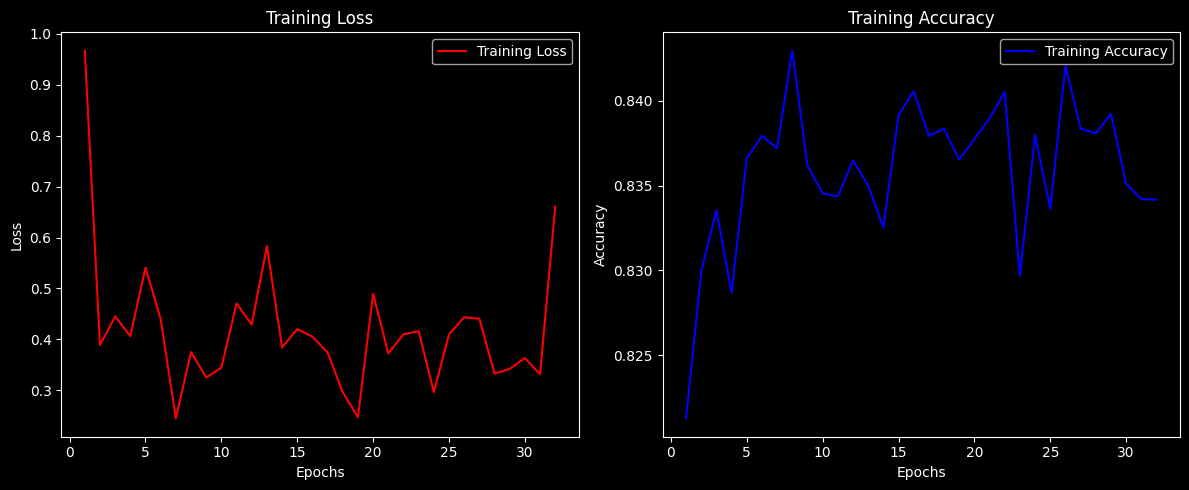

In [7]:
# 打印模型训练过程中的丢失率和精确率变化趋势
loss_acc_callback.plot_metrics()

In [8]:
from sklearn.metrics import confusion_matrix
import os

image_paths = []
label_list = []
test_dir = r'D:\my_deeplearn\image_classify_sdwebui\data\test'


class Preprocess:
    # 预处理
    def __init__(self, width=224, height=224):
        self.width = width
        self.height = height

    def normalize(self, image):
        # 归一化s
        image = image.astype('float32').transpose(2, 0, 1)
        image = (image - 127.5) / 127.5
        return image

    def __call__(self, img_path):
        image = img_open(img_path, 224, 224)
        image = self.normalize(image)
        return image


for root, _, files in os.walk(test_dir):
    for file in files:
        label = int(os.path.basename(root))
        label_list.append(label)
        image_paths.append(os.path.join(root, file))

# 创建预处理实例
preprocess = Preprocess()
# 对图像列表进行预处理
processed_images = [preprocess(img_path) for img_path in image_paths]
# 将列表转换为numpy数组
# processed_images = np.array(processed_images)
# 堆叠图像
processed_images = np.expand_dims(processed_images, axis=0)
# 使用模型进行预测
results = model.predict(processed_images)
# 解析预测结果
scores = results[0][0]
# 使用np.argmax获取预测的类别
predicted_classes = np.argmax(scores, axis=1)

cm = confusion_matrix(label_list, predicted_classes)

tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(precision, recall)

Predict begin...
step 1/1 [==============================] - 25s/step
Predict samples: 1000
0.7291139240506329 0.576
